# **CodSoft Data Science Internship**
Name: Prachiti Raut

# 💳 CREDIT CARD FRAUD DETECTION


Credit card fraud causes significant losses for businesses and customers.
The goal of this project is to build a **machine learning model** that can identify fraudulent transactions.


### Problem Statement:
- Detect fraudulent transactions in a dataset.
- Deal with **class imbalance** (fraud cases are rare).
- Preprocess and normalize the data.
- Train models (Logistic Regression, Random Forest, etc.).
- Evaluate using **precision, recall, and F1-score**.
- Use resampling techniques (oversampling/undersampling) to improve performance.

# Step 1: Import Libraries
We need libraries for data handling, visualization, preprocessing, and ML models.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Imbalanced-learn for SMOTE
from imblearn.over_sampling import SMOTE

# Step 2: Load the Dataset
Dataset contains anonymized credit card transaction details.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/sample_data/creditcard.csv'
data = pd.read_csv(file_path)
print(data.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

# Dataset Description


- **Features V1–V28**: Principal components obtained using **PCA** (sensitive info like user identity and card details were transformed for confidentiality).
- **Feature 'Time'**: Seconds elapsed between each transaction and the first transaction in the dataset.
- **Feature 'Amount'**: Transaction amount — useful for **cost-sensitive learning** (since larger amounts may have bigger impact if fraudulent).
- **Feature 'Class'**: Response variable
- `0` → Genuine transaction
- `1` → Fraudulent transaction

# Step 3: Exploratory Data Analysis (EDA)
Check class distribution, missing values, and imbalance.

In [ ]:
print("Missing values in dataset:\n", data.isnull().sum())

# Drop rows where target variable 'Class' is missing → critical to avoid ValueError
data = data.dropna(subset=['Class'])

# Fill any missing numeric feature values with column median
data = data.fillna(data.median())

Missing values in dataset:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

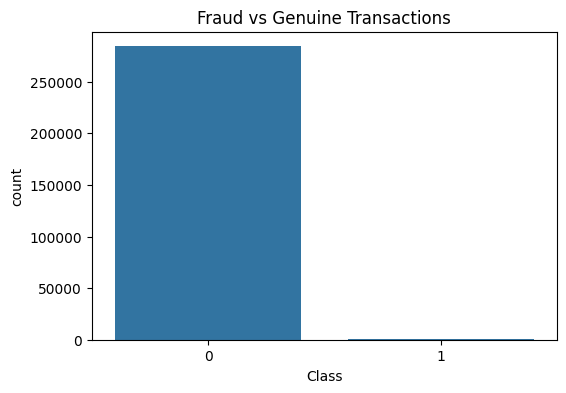

In [ ]:
print(data.info())
print(data['Class'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=data)
plt.title("Fraud vs Genuine Transactions")
plt.show()

**Insight:**
- Dataset is highly imbalanced → Fraud cases are very rare compared to genuine.
- Handling this imbalance is crucial for model performance.

# Step 4: Feature Scaling for Amount
- The 'Amount' column has a wide range of values.
- We create 'Normalized_Amount' using StandardScaler (mean=0, std=1)
- This avoids issues for ML algorithms sensitive to feature scale.


In [ ]:
scaler = StandardScaler()
data['Normalized_Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1,1))

# Drop original 'Amount' column
data = data.drop(['Amount'], axis=1)

# Step 5: Split into Features and Target

In [ ]:
X = data.drop('Class', axis=1)  # features
y = data['Class']               # target

# Train-test split (80%-20%), stratify to keep class ratio consistent
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Fraud cases in training set:", sum(y_train))
print("Fraud cases in test set:", sum(y_test))

Training set shape: (227845, 30)
Testing set shape: (56962, 30)
Fraud cases in training set: 394
Fraud cases in test set: 98


# Step 6: Scale 'Time' Column
- 'Time' feature has large numeric values → scaling improves model performance.
- 'Normalized_Amount' is already scaled.

In [ ]:
scaler_time = StandardScaler()
X_train[['Time']] = scaler_time.fit_transform(X_train[['Time']])
X_test[['Time']] = scaler_time.transform(X_test[['Time']])

# Step 7: Handle Class Imbalance (SMOTE Oversampling)
- Fraud cases << Genuine cases.
- SMOTE generates synthetic fraud samples to balance training data.

In [ ]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("After SMOTE Oversampling:")
print(y_train_res.value_counts())  # Fraud (1) and Genuine (0) counts are now equal


After SMOTE Oversampling:
Class
0    227451
1    227451
Name: count, dtype: int64


# Step 8: Train Models

In [ ]:
# Logistic Regression → interpretable, decent baseline
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000)

In [ ]:
# Random Forest → handles complex patterns, robust
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
rf_model.fit(X_train_res, y_train_res)

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)

# Step 9: Evaluate

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    print(f"\n🔎 Model: {model_name}")
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_test, y_prob):.4f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()


🔎 Model: Logistic Regression
              precision    recall  f1-score   support

           0     0.9999    0.9743    0.9869     56864
           1     0.0579    0.9184    0.1090        98

    accuracy                         0.9742     56962
   macro avg     0.5289    0.9463    0.5479     56962
weighted avg     0.9982    0.9742    0.9854     56962

ROC-AUC Score: 0.9699124585118234


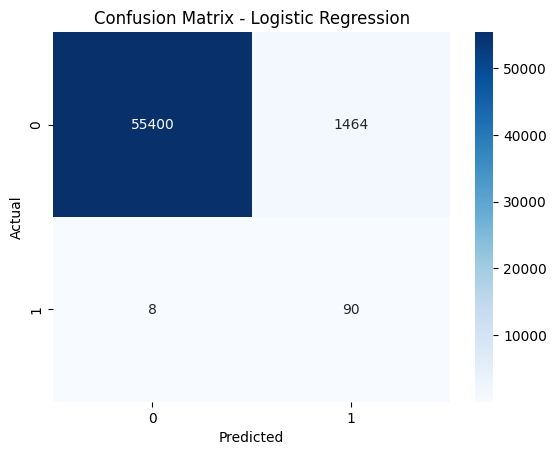

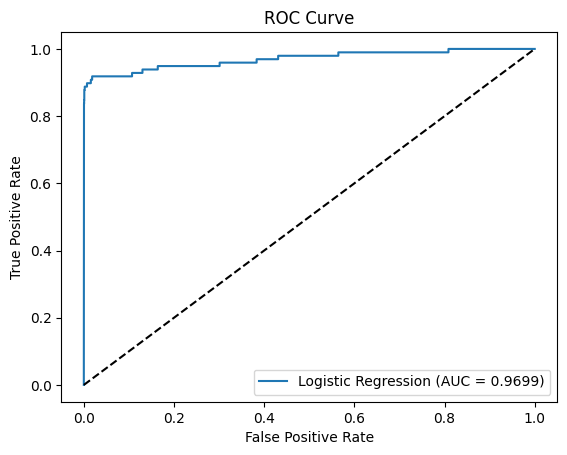

In [ ]:
# Evaluate Logistic Regression
evaluate_model(log_model, X_test, y_test, "Logistic Regression")


🔎 Model: Random Forest
              precision    recall  f1-score   support

           0     0.9998    0.9980    0.9989     56864
           1     0.4365    0.8776    0.5831        98

    accuracy                         0.9978     56962
   macro avg     0.7182    0.9378    0.7910     56962
weighted avg     0.9988    0.9978    0.9982     56962

ROC-AUC Score: 0.9843122832278662


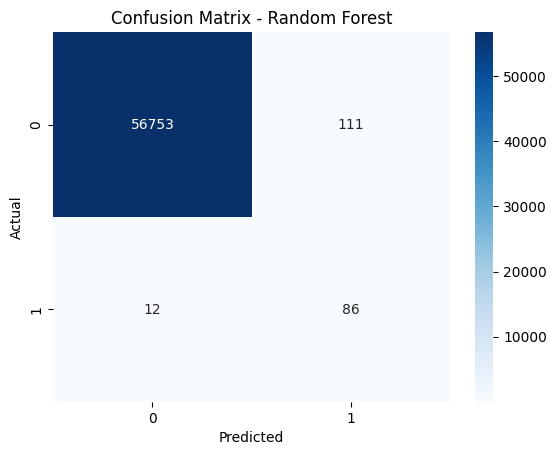

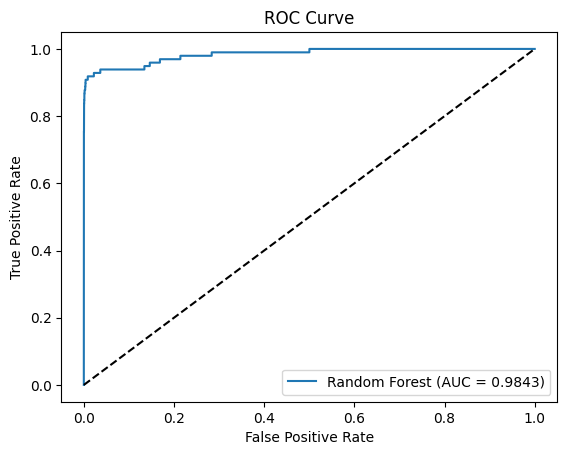

In [ ]:
# Evaluate Random Forest
evaluate_model(rf_model, X_test, y_test, "Random Forest")

# Step 10: Business Insights
📌 Business Insights:
- Fraudulent transactions are extremely rare → imbalance is the biggest challenge.
- Logistic Regression:
  ✅ Simple, interpretable, decent recall (important to catch frauds).
- Random Forest:
  ✅ Higher ROC-AUC, better accuracy, robust in real-world scenarios.
- Business Tradeoff:
  ⚠️ Prioritize high recall → better to flag some genuine transactions
     than to miss a fraudulent one.
- Business Value:
  ✅ Can be integrated into banking/payment systems
     to automatically flag suspicious transactions in real time.